# Tutorial: How to load and use the datasets generated by detect.py

In [93]:
import sys
sys.path.append("../")
sys.path.append("../trajectorynet")
from trajectorynet.utility.dataset import load_dataset

In [94]:
# The path to the joblib file
# this can be a file or a directory containing multiple joblib files
# NOTE: if directory path is given, the joblib files get concatenated
# so it is recommended to use the directory path option only if the 
# datasets are from the same source
dataset_path = "/media/pecneb/970evoplus/cv_research_video_dataset/Bellevue_116th_NE12th_24h"

## To load the dataset
- Use the load_dataset() function, which will return a numpy array with the TrackedObject instances
- To check the dataset is loaded correctly print out some of the objects, they have a representation string for debugging

In [95]:
dataset = load_dataset(dataset_path)
print(dataset[:11])

Loading datasets: 0it [00:00, ?it/s]

Loading datasets: 16it [00:59,  2.54s/it]

Error loading /media/pecneb/970evoplus/cv_research_video_dataset/Bellevue_116th_NE12th_24h/Bellevue_116th_NE12th__2017-09-11_17-08-39.joblib: 


Loading datasets: 21it [01:08,  3.28s/it]


[ID: 3, Label: car, X: 353.0, Y: 186.5, VX: -0.008741297073750584, VY: -0.025704210033677358, AX: -0.008689494204539967, AY: -0.007018739786841546, Time since update: 10, Max age: 10, Dataset: /media/pecneb/970evoplus/cv_research_video_dataset/Bellevue_116th_NE12th_24h/Bellevue_116th_NE12th__2017-09-11_05-08-39.joblib
 ID: 10, Label: car, X: 352.5, Y: 187.0, VX: -0.053568176130018116, VY: 0.03412523466347988, AX: -0.009376365140276136, AY: -0.04060866531947583, Time since update: 10, Max age: 10, Dataset: /media/pecneb/970evoplus/cv_research_video_dataset/Bellevue_116th_NE12th_24h/Bellevue_116th_NE12th__2017-09-11_05-08-39.joblib
 ID: 11, Label: car, X: 352.5, Y: 188.0, VX: -0.084207270067949, VY: 0.03457767397727453, AX: 0.08417869593865578, AY: 0.0009073564077700796, Time since update: 10, Max age: 10, Dataset: /media/pecneb/970evoplus/cv_research_video_dataset/Bellevue_116th_NE12th_24h/Bellevue_116th_NE12th__2017-09-11_05-08-39.joblib
 ID: 12, Label: car, X: 351.0, Y: 186.0, VX: -0.

In [106]:
def stats(dataset):
    print(f"Number of trajectories in dataset: {len(dataset)}")
    object_labels = {traj.label for traj in dataset}
    print(f"Object labels: {object_labels}")
    history_lengths = [len(traj.history) for traj in dataset]
    max_history_length = max(history_lengths)
    min_history_length = min(history_lengths)
    print(f"Maximum history length: {max_history_length}")
    print(f"Minimum history length: {min_history_length}")
    avg_length = sum(history_lengths) / len(history_lengths)
    print(f"Average history length: {avg_length}")
    std = (sum([(x - avg_length) ** 2 for x in history_lengths]) / len(history_lengths)) ** 0.5
    print(f"Standard deviation of history lengths: {std}")
    return history_lengths, object_labels

history_lengths, object_labels = stats(dataset)

Number of trajectories in dataset: 19316
Object labels: {'motorcycle', 'truck', 'bus', 'car'}
Maximum history length: 3000
Minimum history length: 3
Average history length: 95.08883826879271
Standard deviation of history lengths: 237.21019523105392


## Visualize the unfiltered dataset by using matplotlib

In [107]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

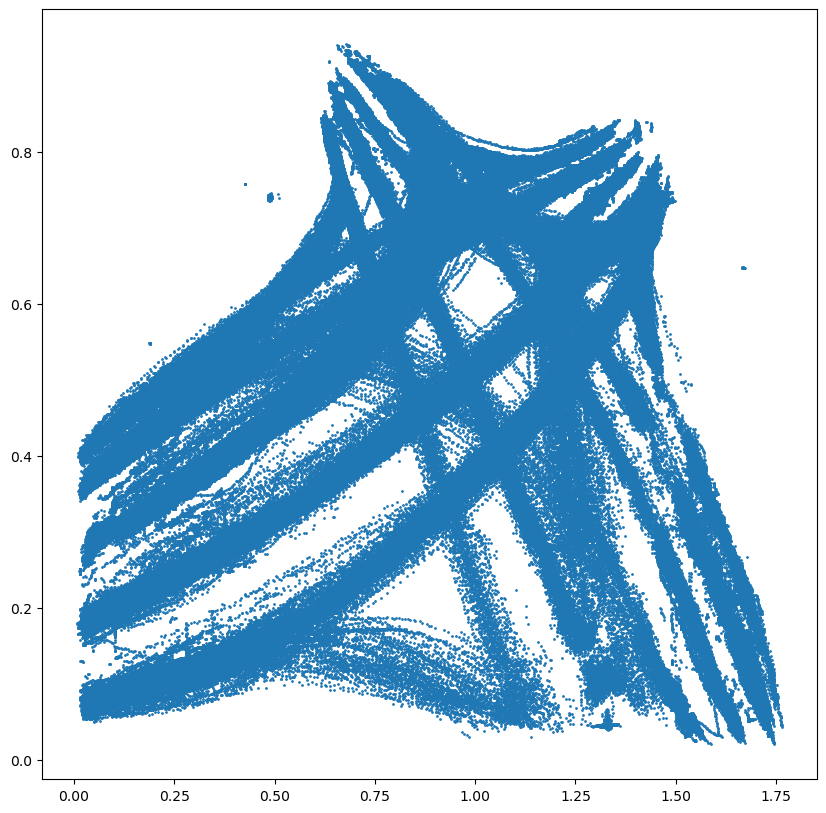

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
X = np.concatenate([o.history_X for o in dataset])
Y = 1 - np.concatenate([o.history_Y for o in dataset])
ax.scatter(x=X, y=Y, s=1)

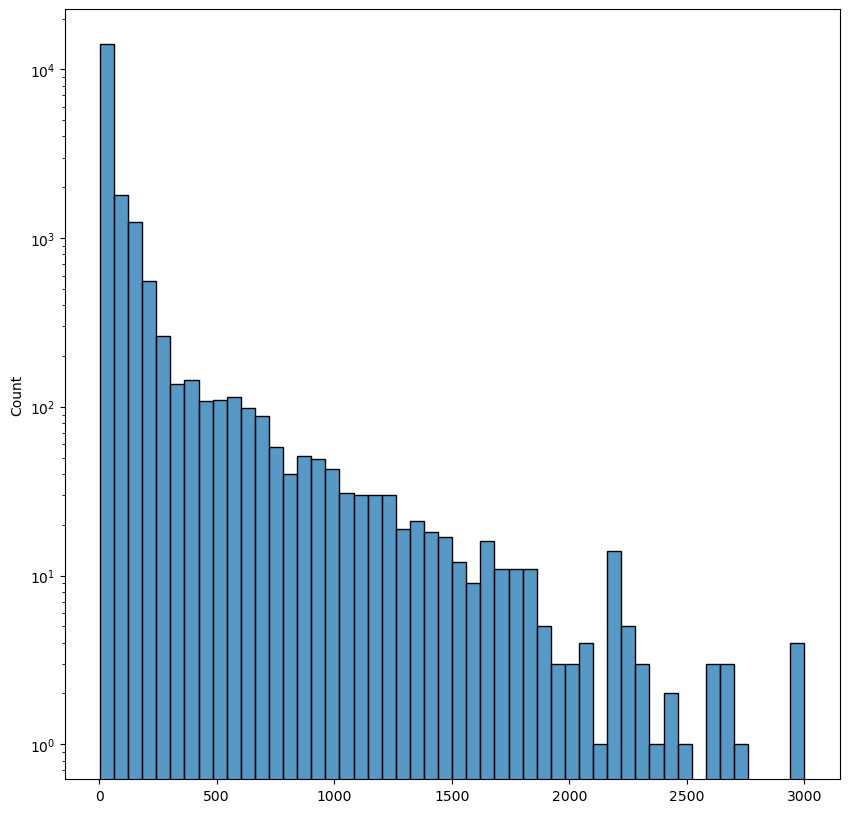

In [109]:
# Plot histogram of history lengths with seaborn (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(history_lengths, ax=ax, bins=50)
ax.set_yscale('log')

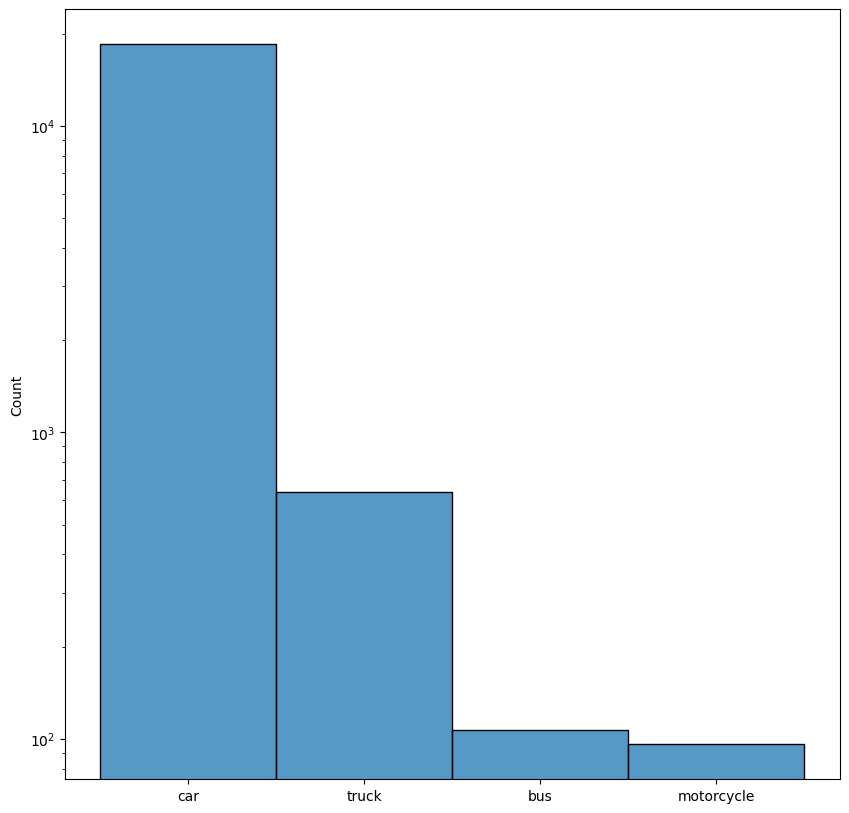

In [110]:
# Make historgram of object labels (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot([traj.label for traj in dataset], bins=len(object_labels))
ax.set_yscale('log')

## Apply filtering on dataset
- Filtering based on first and last detection distance from each other
- Filtering based on first and last detection distance from relative edges
- Filtering based on detections distance from each other 

In [111]:
from trajectorynet.utility.preprocessing import (
    filter_out_false_positive_detections_by_enter_exit_distance,
    filter_out_noise_trajectories,
    filter_out_edge_detections,
    euclidean_distance
)

In [112]:
distances = [
    euclidean_distance(
        traj.history_X[0], traj.history_X[-1], traj.history_Y[0], traj.history_Y[-1]
    )
    for traj in dataset
]
max_distance = max(distances)
min_distance = min(distances)
print(f"Maximum distance between start and end points: {max_distance}")
print(f"Minimum distance between start and end points: {min_distance}")
filtered_1 = filter_out_false_positive_detections_by_enter_exit_distance(dataset, 0.4)
distances = [
    euclidean_distance(
        traj.history_X[0], traj.history_X[-1], traj.history_Y[0], traj.history_Y[-1]
    )
    for traj in filtered_1 
]
max_distance = max(distances)
min_distance = min(distances)
print(f"Maximum distance between start and end points: {max_distance}")
print(f"Minimum distance between start and end points: {min_distance}")

Maximum distance between start and end points: 1.6333056375615485
Minimum distance between start and end points: 0.0
Maximum distance between start and end points: 1.6333056375615485
Minimum distance between start and end points: 0.40044163420976847


In [114]:
history_lengths_filtered_1, object_labels = stats(filtered_1)

Number of trajectories in dataset: 3836
Object labels: {'motorcycle', 'truck', 'bus', 'car'}
Maximum history length: 3000
Minimum history length: 10
Average history length: 312.6793534932221
Standard deviation of history lengths: 391.1995321219453


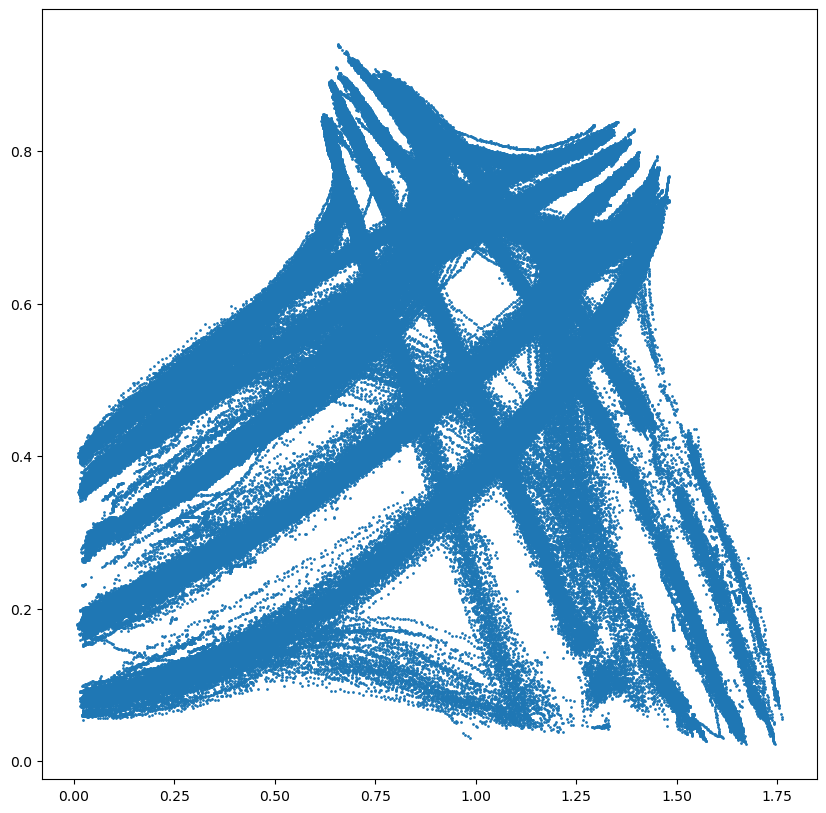

In [119]:
# Scatter plot of filtered trajectories
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
X = np.concatenate([o.history_X for o in filtered_1])
Y = 1 - np.concatenate([o.history_Y for o in filtered_1])
ax.scatter(x=X, y=Y, s=1)

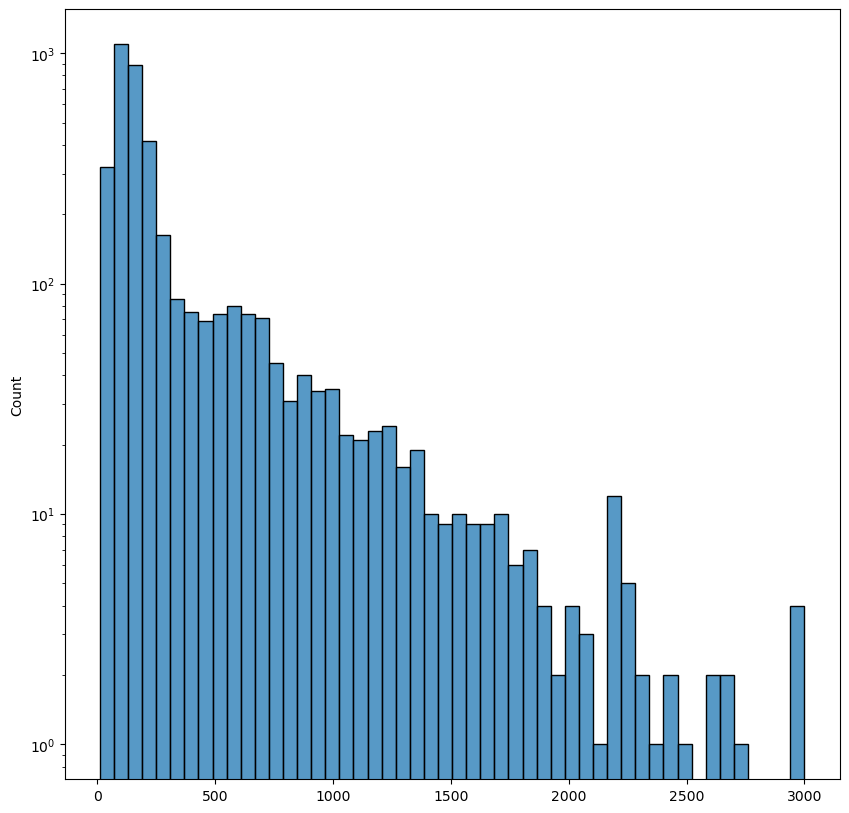

In [115]:
# Plot histogram of history lengths with seaborn (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(history_lengths_filtered_1, ax=ax, bins=50)
ax.set_yscale('log')

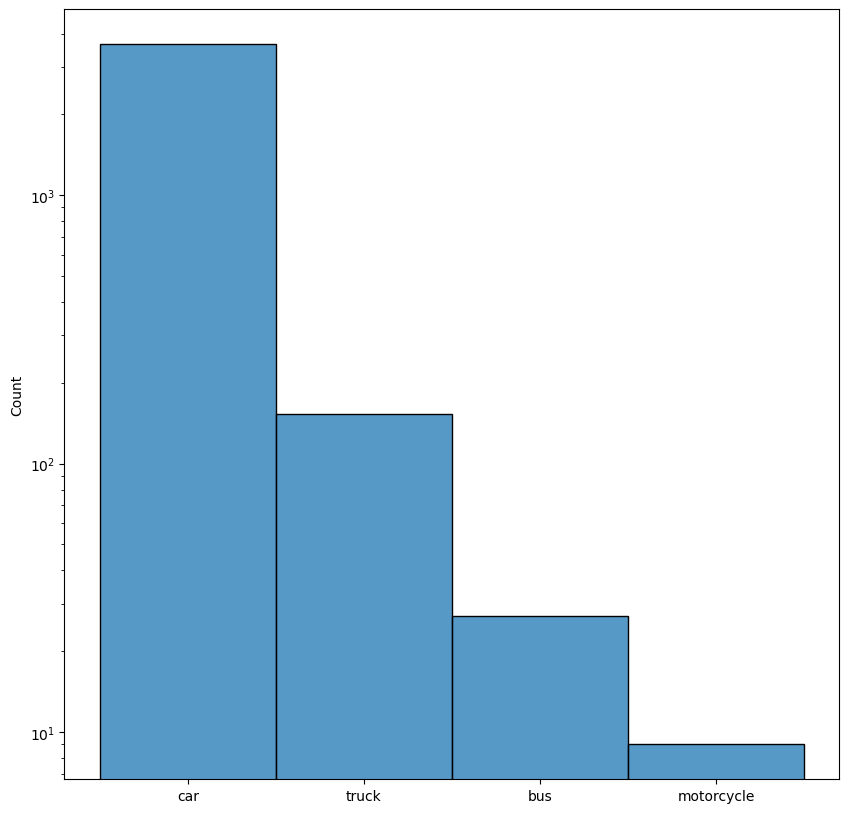

In [116]:
# Make historgram of object labels (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot([traj.label for traj in filtered_1], bins=len(object_labels))
ax.set_yscale('log')